# Resting state simulation

This is the second notebook in a series illustrating the workflow of the usecase of virtual brain modeling and inference in the context of neurodegenerative disease (NDD). Here, as a second step, we show how the simulation is configured for a single subject, and discuss the individual components.

In [4]:
!date -I

%load_ext autoreload
%autoreload 2
%matplotlib inline

import numpy as np
import matplotlib.pylab as plt
import pandas as pd

from src.data.data_loader import Synthetic

from tvb.simulator.lab import *

2023-05-26


## Creating the Brain Network Model

### The neural mass model

Here we use the Montbrio Pazo Roxin model to govern the dynamical behavior of each of the nodes of the network. In TVB, this model is already implemented in the `tvb.models.MontbrioPazoRoxin` class.

In [5]:
mpr = models.MontbrioPazoRoxin(
    J = np.r_[14.5],
    eta = np.r_[-4.6],
    tau  = np.r_[1.0],
    Delta = np.r_[0.7]
)

In [41]:
mpr

### Connectivity

From the synthetic dataset, we pick a subject.

In [6]:
dset = Synthetic()

subject = dset.subjects[0]
subject

'sub-001'

We start with loading the connectivity of that subject using the corresponding convenience function of the `Synthetic` dataset class. The returned data is an instance of `tvb.connectivity.Connectivity`, the data type for the whole-brain network.

In [7]:
conn = dset.load_connectivity(subject)
conn.speed = np.r_[np.inf]
conn.configure() # to compute number of connections etc. to be shown below
conn

,value
Number of connections,7340
Number of regions,88
Undirected,True
areas is None,True
tract_lengths,"[min, median, max] = [1, 1, 1] dtype = float64 shape = (88, 88)"
tract_lengths (connections),"[min, median, max] = [1, 1, 1] dtype = float64 shape = (7340,)"
tract_lengths-non-zero,"[min, median, max] = [1, 1, 1] dtype = float64 shape = (7744,)"
weights,"[min, median, max] = [0, 0.00409626, 1] dtype = float64 shape = (88, 88)"
weights-non-zero,"[min, median, max] = [0.000128008, 0.0047363, 1] dtype = float64 shape = (7340,)"


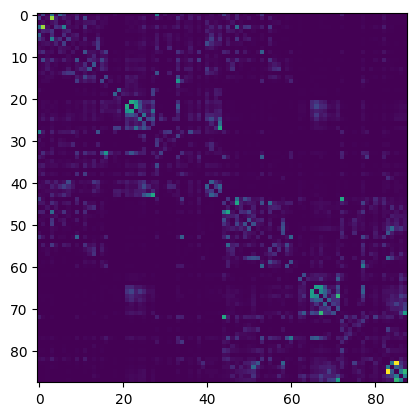

In [44]:
plt.imshow(conn.weights)

### Brain Network Model

To put these two main elements together in a TVB simulator, we need to configure additional components dealing with the network coupling scaling, and numerical integration.



In [45]:
sim = simulator.Simulator(
    model=mpr,
    connectivity=conn,
    coupling=coupling.Linear(a=np.r_[0.9]),
    integrator=integrators.HeunStochastic(
        dt=0.01,
        noise=noise.Additive(nsig=0.037*np.r_[1,2])
    ),
    monitors=[monitors.TemporalAverage(period=.1)]                
).configure()

With the simulation configured, we can now proceed and simulate the resting state data.

## Running the simulation and plotting the results.

The MPR model has a faster backend available in TVB.

In [3]:
from tvb.simulator.backend.nb_mpr import NbMPRBackend

In [32]:
runner = NbMPRBackend()
(tavg_t, tavg_d), = runner.run_sim(sim, simulation_length=30_000)
tavg_t *= 10

We now transform the model activity to BOLD time-series using the Baloon-Windkessel model, again wrapped in a convenience function.

In [1]:
from src.simulation import tavg_to_bold

/scratch/snx3000/bp000275/virtual_ndd_brain/env/lib/python3.9/site-packages/tvb/datatypes/surfaces.py:60: UserWarning: Geodesic distance module is unavailable; some functionality for surfaces will be unavailable.
  warnings.warn(msg)


In [34]:
bold_t, bold_d = tavg_to_bold(tavg_t, tavg_d, tavg_period=1., connectivity=sim.connectivity, decimate=500)

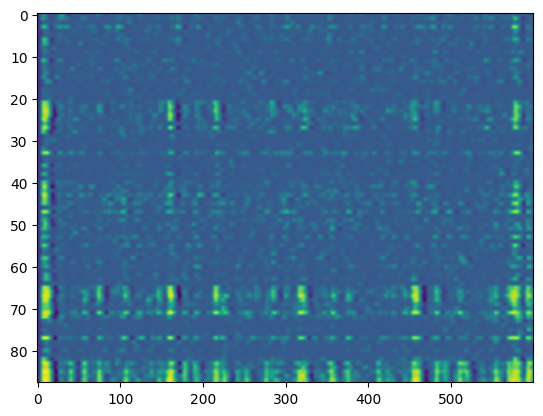

In [36]:
plt.imshow(bold_d[:,0,:,0].T, aspect='auto')

From here, we can apply the same analysis as we did in the case of the empirical data. 

FCD

## Parameter exploration

Running large number of simulations is required both for the systematic parameter exploration and for the Simulation Based Inference. Larger workloads are usually better ofloaded to the dedicated High Performance Computing infrastructure. Below we show how the parameter sweep is configured with the help of the `tvb_inversion` package, and executed on a SLURM-based cluster.

We start with defining the parameter sweep. In the `tvb_inversion` this means creating a template simulator instance, and a table of parameters for which the simulation will be repeated. In the example below, we copy the simulation defining code from above, and define a range of coupling strength values `coupling.a` over which we want to run the sweep.

In [3]:
from tvb_inversion.utils import init_experiment, data_path
from tvb_inversion.parameters import SimSeq

/scratch/snx3000/bp000275/virtual_ndd_brain/env/lib/python3.9/site-packages/tvb/datatypes/surfaces.py:60: UserWarning: Geodesic distance module is unavailable; some functionality for surfaces will be unavailable.
  warnings.warn(msg)


In [8]:
seq = SimSeq(
    template = simulator.Simulator(
        model=mpr,
        connectivity=conn,
        coupling=coupling.Linear(),
        integrator=integrators.HeunStochastic(
            dt=0.01,
            noise=noise.Additive(nsig=0.037*np.r_[1,2])
        ),
        monitors=[monitors.TemporalAverage(period=.1)]                
    ).configure(),
    params=['coupling.a'],
    values=[
        [
            np.r_[a],                           # coupling scaling G
        ] 
        for a in np.arange(0.5, 1.2,0.05)       # list of values of G
    ]
)

   INFO  history has n_time=1 n_cvar=2 n_node=88 n_nmode=1, requires 0.47 MB
   INFO  sparse history has n_nnzw=7340, i.e. 94.78 % sparse
  ERROR  Bad Simulator.integrator.noise.nsig shape: (2, 1, 1)
   INFO  history has n_time=1 n_cvar=2 n_node=88 n_nmode=1, requires 0.47 MB
   INFO  sparse history has n_nnzw=7340, i.e. 94.78 % sparse


In [31]:
len(seq.values)

14

For this small number we could run the sweep locally with `tvb_inversion.utils.run_local`, but we will use this small task to demonstrate the steps of ofloading the computation to the HPC cluster.

First we initialize the folder for the experiment, where the codes, scripts and results will reside. It will get pre-filled with necessary helper codes to aid provenance and the execution on the cluster.

In [33]:
init_experiment(seq, '../../experiments/01_single_subject_sweep')

Experiment folder initialized, please edit the sweep.py and sweep.sh files.


../../experiments/01_single_subject_sweep/
  sweep.sh
  sweep.py
  test.sh

In the `sweep.sh` we define the cluster-specific parameters for the scheduler (such as partition, etc.), and the size of requested resources such as the number of nodes we want to saturate with the parameter sweep. In the `sweep.py` we copy the code from the cell above, which constructs the simulation sequence from given parameter values (function `init_seq`). More instructions are in the script file.

Having this set up, we can commit this folder to the git version control and copy the whole project to the HPC cluster (e.g. through a shared remote). When done, we can execute the experiment on the cluster by running the `sbatch sweep.sh` command in the experiment folder. The resulting hdf5 file contains the results of the sweep, so after copying it back, we can load it and visualize the results.

In [34]:
%ls '../../experiments/01_single_subject_sweep/results'

0.npy  10.npy  1.npy  2.npy  3.npy  4.npy  5.npy  6.npy  7.npy  8.npy  9.npy


In [35]:
len(seq.values)

14

In [36]:
results = [
    np.load(f'../../experiments/01_single_subject_sweep/results/{i}.npy', allow_pickle=True)
    for i in range(len(seq.values))
    if os.path.isfile(f'../../experiments/01_single_subject_sweep/results/{i}.npy')
]

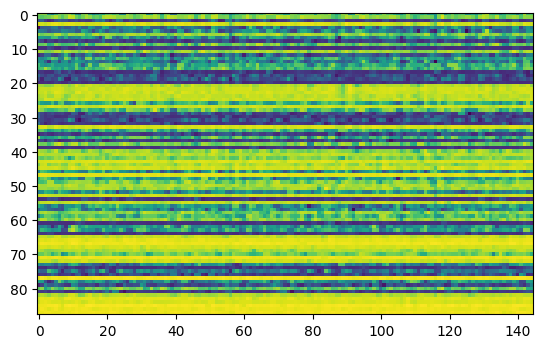

In [125]:
bold_t, bold_d, fcd_var = results[-1]

plt.imshow(bold_d[5:,0,:,0].T)

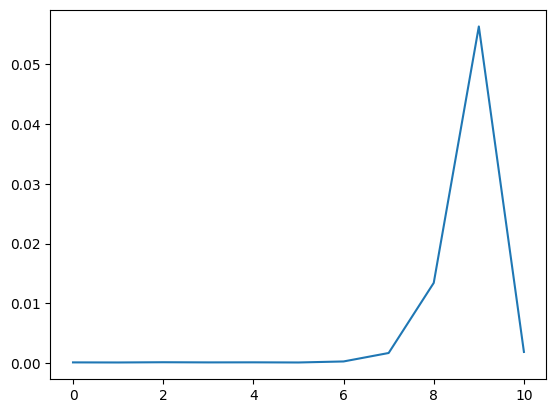

In [38]:
plt.plot([fcd_var for _, _, fcd_var in results])

We can now run this for the whole cohort.

In [11]:
from tvb_inversion.parameters import ParamGetter

# A function to translate subject id (sweep parameter) to a connectivity instance
class ConnectivityGetter(ParamGetter):
    def __call__(self, subj_id):
        return Synthetic().load_connectivity(subj_id)

seq = SimSeq(
    template = simulator.Simulator(
        model=mpr,
        connectivity=conn,
        coupling=coupling.Linear(),
        integrator=integrators.HeunStochastic(
            dt=0.01,
            noise=noise.Additive(nsig=0.037*np.r_[1,2])
        ),
        monitors=[monitors.TemporalAverage(period=.1)]                
    ).configure(),
    params=['connectivity','coupling.a'],
    values=[
        [
            subj,
            np.r_[a],                           # coupling scaling G
        ]
        for subj in dset.subjects
        for a in np.arange(0.5, 1.2,0.05)       # list of values of G
    ],
    getters=[ConnectivityGetter(),None]
)

  ERROR  Bad Simulator.integrator.noise.nsig shape: (2, 1, 1)


In [10]:
experiment_path = '../../experiments/02_cohort_sweep'

In [107]:
init_experiment(seq, experiment_path)

Experiment folder initialized, please edit the sweep.py and sweep.sh files.


../../experiments/02_cohort_sweep/
  sweep.sh
  sweep.py

In [68]:
# how long in hours till we have all the results (adjust time per task (simulation above), and avaialble nodes
# tasks          minutes  hours  node_cpus  nodes
len(seq.values) *   5   / 60   /   12     / 10

1.1180555555555556

When all is done, we can load the results and plot for each subject the value of the working point

In [2]:
def load_results(values, experiment_path):
    files = [f'{experiment_path}/results/{i}.npy' for i in range(len(values))]
    fcd_vars = [np.load(f, allow_pickle=True)[-1] if os.path.isfile(f) else None for f in files ]
    return pd.DataFrame(
        [ 
            ( subj, a.item(), fcd_var )  
             for fcd_var, (subj, a) in 
             zip(fcd_vars, seq.values)
        ],
        columns=['subj', 'a', 'fcd_var']
    )

In [15]:
df = load_results(seq.values, experiment_path)

In [164]:
df

,subj,a,fcd_var
0,sub-001,0.50,0.000110
1,sub-001,0.55,0.000101
2,sub-001,0.60,0.000192
3,sub-001,0.65,0.013660
4,sub-001,0.70,0.003142
...,...,...,...
1605,sub-115,0.95,NaN
1606,sub-115,1.00,NaN
1607,sub-115,1.05,NaN
1608,sub-115,1.10,NaN


We can plot the values of the sweep, missing values will render as white space. This can be due to technical issues or numerical divergence. We can inspect the logs, adjust the integration step and re-run. To move the code and data betwen the cluster and the workbench, git and dvc are used.

In [1]:
import seaborn as sns

<Axes: xlabel='a', ylabel='subj'>

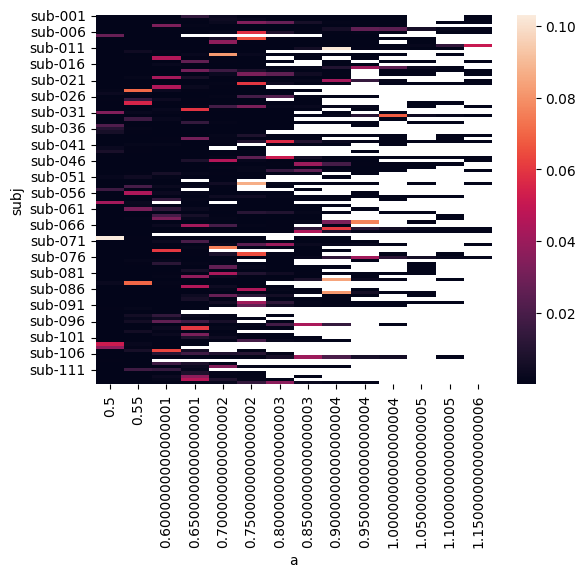

In [16]:
df.pivot(index='subj', columns='a', values='fcd_var').pipe(sns.heatmap)

In [12]:
from tvb_inversion.utils import load_params

In [13]:
params, values = load_params(f'{experiment_path}/params.npz')
seq.params = params
seq.values = values

In [14]:
df = load_results(seq.values, experiment_path)
df.dropna().shape, df.shape

((1420, 3), (1610, 3))

<Axes: xlabel='a', ylabel='subj'>

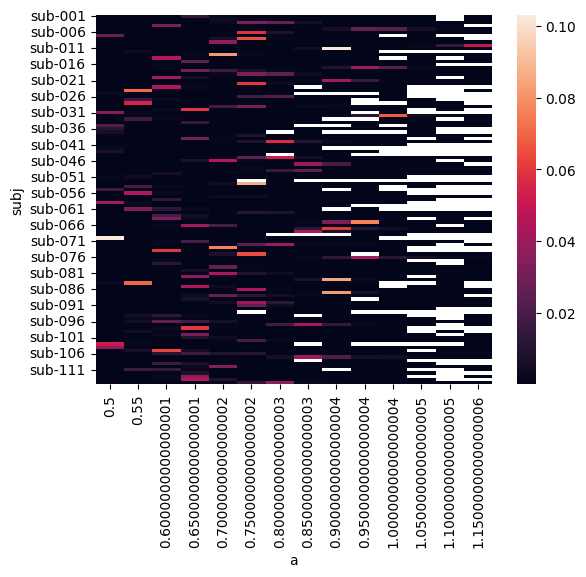

In [15]:
df.pivot(index='subj', columns='a', values='fcd_var').pipe(sns.heatmap)

In [16]:
rejects = [ f'{experiment_path}/results/{i}.npy' 
    for i in df[df.fcd_var.isna()].index
]

np.savetxt(f'{experiment_path}/delete.txt', rejects, fmt='%s')